# Cleaning: BJH021


This script cleans the data both by abnormal trials and by noisy channels and epileptic activity.


### Prep

In [1]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [2]:
%matplotlib qt5

In [3]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [4]:
## Prep paths ##

subject = 'BJH021'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [5]:
## Load Data ##

raw_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_ieeg-1.fif...
    Range : 2086000 ... 3156499 =   1043.000 ...  1578.249 secs
Ready.


In [6]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.filter(l_freq=1, h_freq=150) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Reading 0 ... 3156499  =      0.000 ...  1578.249 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 6601 samples (3.300 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 

In [7]:
## Load/Save Filtered Data ##

# save #
# filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# load #
filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif")
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_ieeg-1.fif...
    Range : 2086000 ... 3156499 =   1043.000 ...  1578.249 secs
Ready.
480 events found
Event IDs: [0 1]


In [8]:
filtered_notch_data.info['ch_names']

['A1',
 'A2',
 'A3',
 'A4',
 'REF1',
 'REF2',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A16',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'B12',
 'B13',
 'B14',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6',
 'G7',
 'G8',
 'G9',
 'G10',
 'G11',
 'G12',
 'G13',
 'G14',
 'H1',
 'H2',
 'H3',
 'H4',
 'H5',
 'H6',
 'H7',
 'H8',
 'H9',
 'H10',
 'H11',
 'H12',
 'H13',
 'H14',
 'H15',
 'H16',
 'I1',
 'I2',
 'I3',
 'I4',
 'I5',
 'I6',
 'I7',
 'I8',
 'I9',
 'I10',
 'I11',
 'I12',
 'J1',
 'J2',
 'J3',
 'J4',
 'J5',
 'J6',
 'J7',
 'J8',
 'J9',
 'J10',
 'J11',
 'J12',


## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: 

Noisy channels: 

In [9]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
bob_bad_channels = ['B2', 'B1', 'C1', 'C2', 'C3', 'C4', 'E8', 'O1']
filtered_notch_data.info['bads'].extend(bob_bad_channels)  

# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = ['EMPTY',
 'EMPTY_230',
 'EMPTY_231',
 'fp1',
 'f3',
 'c3',
 'p3',
 'o1',
 'fp2',
 'f4',
 'c4',
 'p4',
 'o2',
 'f7',
 't7',
 'p7',
 'f8',
 't8',
 'p8',
 'f9',
 'f10',
 'fpz',
 'fz',
 'cz',
 'pz',
 'oz',
 'EKG1',
 'EKG2']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

<Raw | BJH021_notched_filtered_ieeg.fif, 257 x 3156500 (1578.2 s), ~258 kB, data not loaded>

In [10]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in raw_fif.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [raw_fif.info['ch_names'][i] for i in bad_channels_index]

raw_fif.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
bob_bad_channels = ['B2', 'B1', 'C1', 'C2', 'C3', 'C4', 'E8', 'O1']
raw_fif.info['bads'].extend(bob_bad_channels)  

# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = ['EMPTY',
 'EMPTY_230',
 'EMPTY_231',
 'fp1',
 'f3',
 'c3',
 'p3',
 'o1',
 'fp2',
 'f4',
 'c4',
 'p4',
 'o2',
 'f7',
 't7',
 'p7',
 'f8',
 't8',
 'p8',
 'f9',
 'f10',
 'fpz',
 'fz',
 'cz',
 'pz',
 'oz',
 'EKG1',
 'EKG2']

raw_fif.info['bads'].extend(scalp_dc_channels)
raw_fif

<Raw | BJH021_raw_ieeg.fif, 257 x 3156500 (1578.2 s), ~6.04 GB, data loaded>

#### Bad Epochs

From interactive session

OrderedDict([('onset', 150.02797979687392), ('duration', 0.1893907751345978), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 180.01179324126244), ('duration', 0.10245730458103708), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 250.5178702305566), ('duration', 0.15213357346877387), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 268.2265523281082), ('duration', 0.16765740749622182), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 371.69147208303013), ('duration', 0.19560030874555423), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 628.2482856957466), ('duration', 0.14902880666329565), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 734.2560094643613), ('duration', 0.45640072040635005), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 748.8692390568438), ('duration', 0.2949528465211415), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 808.5246099414348), ('duration', 0.7761917013713173), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 831.0518901211001), ('duration', 0.24838134443893978), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 844.3926192038027), ('duration', 0.5992199934587461), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 900.2477555184793), ('duration', 0.5402294241545178), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 916.3951937933409), ('duration', 0.21733367638398704), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 1024.5043908088), ('duration', 0.3601529494364968), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 1312.9892646077233), ('duration', 0.3011623801321548), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 1549.0617345987837), ('duration', 0.46571502082269944), ('description', 'BAD_'), ('orig_time', None)])


In [11]:
# # Annotate Noisy Epochs from Bob's cleaning

# read from csv from interactive session
bad_annots = mne.read_annotations('../ieeg/saved_annotations.fif')   
filtered_notch_data.set_annotations(bad_annots)
raw_fif.set_annotations(bad_annots)

<Raw | BJH021_raw_ieeg.fif, 257 x 3156500 (1578.2 s), ~6.04 GB, data loaded>

## Cleaning Bad Trials

In [15]:
## quality check trials ##

# calculate trial onsets and offsets
sti_raw = filtered_notch_data.get_data(picks = ['STI'])
lengths, positionsm, val  = rle(sti_raw[0])

# lengths, beginnings, endings, for trials
trial_lengths = [lengths[x] for x in np.where(val == 1)]
trial_begins = [positionsm[x] for x in np.where(val == 1)]
trial_ends = trial_lengths[0] + trial_begins[0]
trial_baseline = trial_begins[0] - 1000

# lengths, beginnings, endings, for itis
iti_lengths = [lengths[x] for x in np.where(val == 0)]
iti_begins = [positionsm[x] for x in np.where(val == 0)]
iti_ends = iti_begins[0] + iti_lengths[0]

# save trial lengths for later
np.save(f"{preproc_data_dir}/{subject}_trial_lengths.npy", trial_lengths)

In [17]:
# # exclude bad trials/apochs from r behavioral analysis (paused trials and no biscuits)

onsets = []
durations = []

# load bad trial data
bad_trials = np.genfromtxt(f"{raw_data_dir}/behave/{subject}_bad_trials.csv", delimiter = ',', skip_header = 1)

for bad in bad_trials:
    start, dur = find_bad_trial_times(int(bad), 2000, trial_begins, trial_lengths)
    onsets.append(start)
    durations.append(dur)

# update descriptions
descriptions = ['bad'] * len(durations)


## Visualizing Neural Data

In [19]:
## exclude all bad epochs from both bad trials and investigating neural data ##

# create annotations structure #
bad_annots = mne.Annotations(onset=onsets,
                               duration=durations,
                               description=descriptions,
                               orig_time=filtered_notch_data.info['meas_date'])

# apply to filtered data #
filtered_notch_data.set_annotations(bad_annots)


# apply to not filtered data #
raw_fif.set_annotations(bad_annots)

<Raw | BJH021_raw_ieeg.fif, 257 x 3156500 (1578.2 s), ~6.04 GB, data loaded>

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Using matplotlib as 2D backend.
Opening raw-browser...


libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


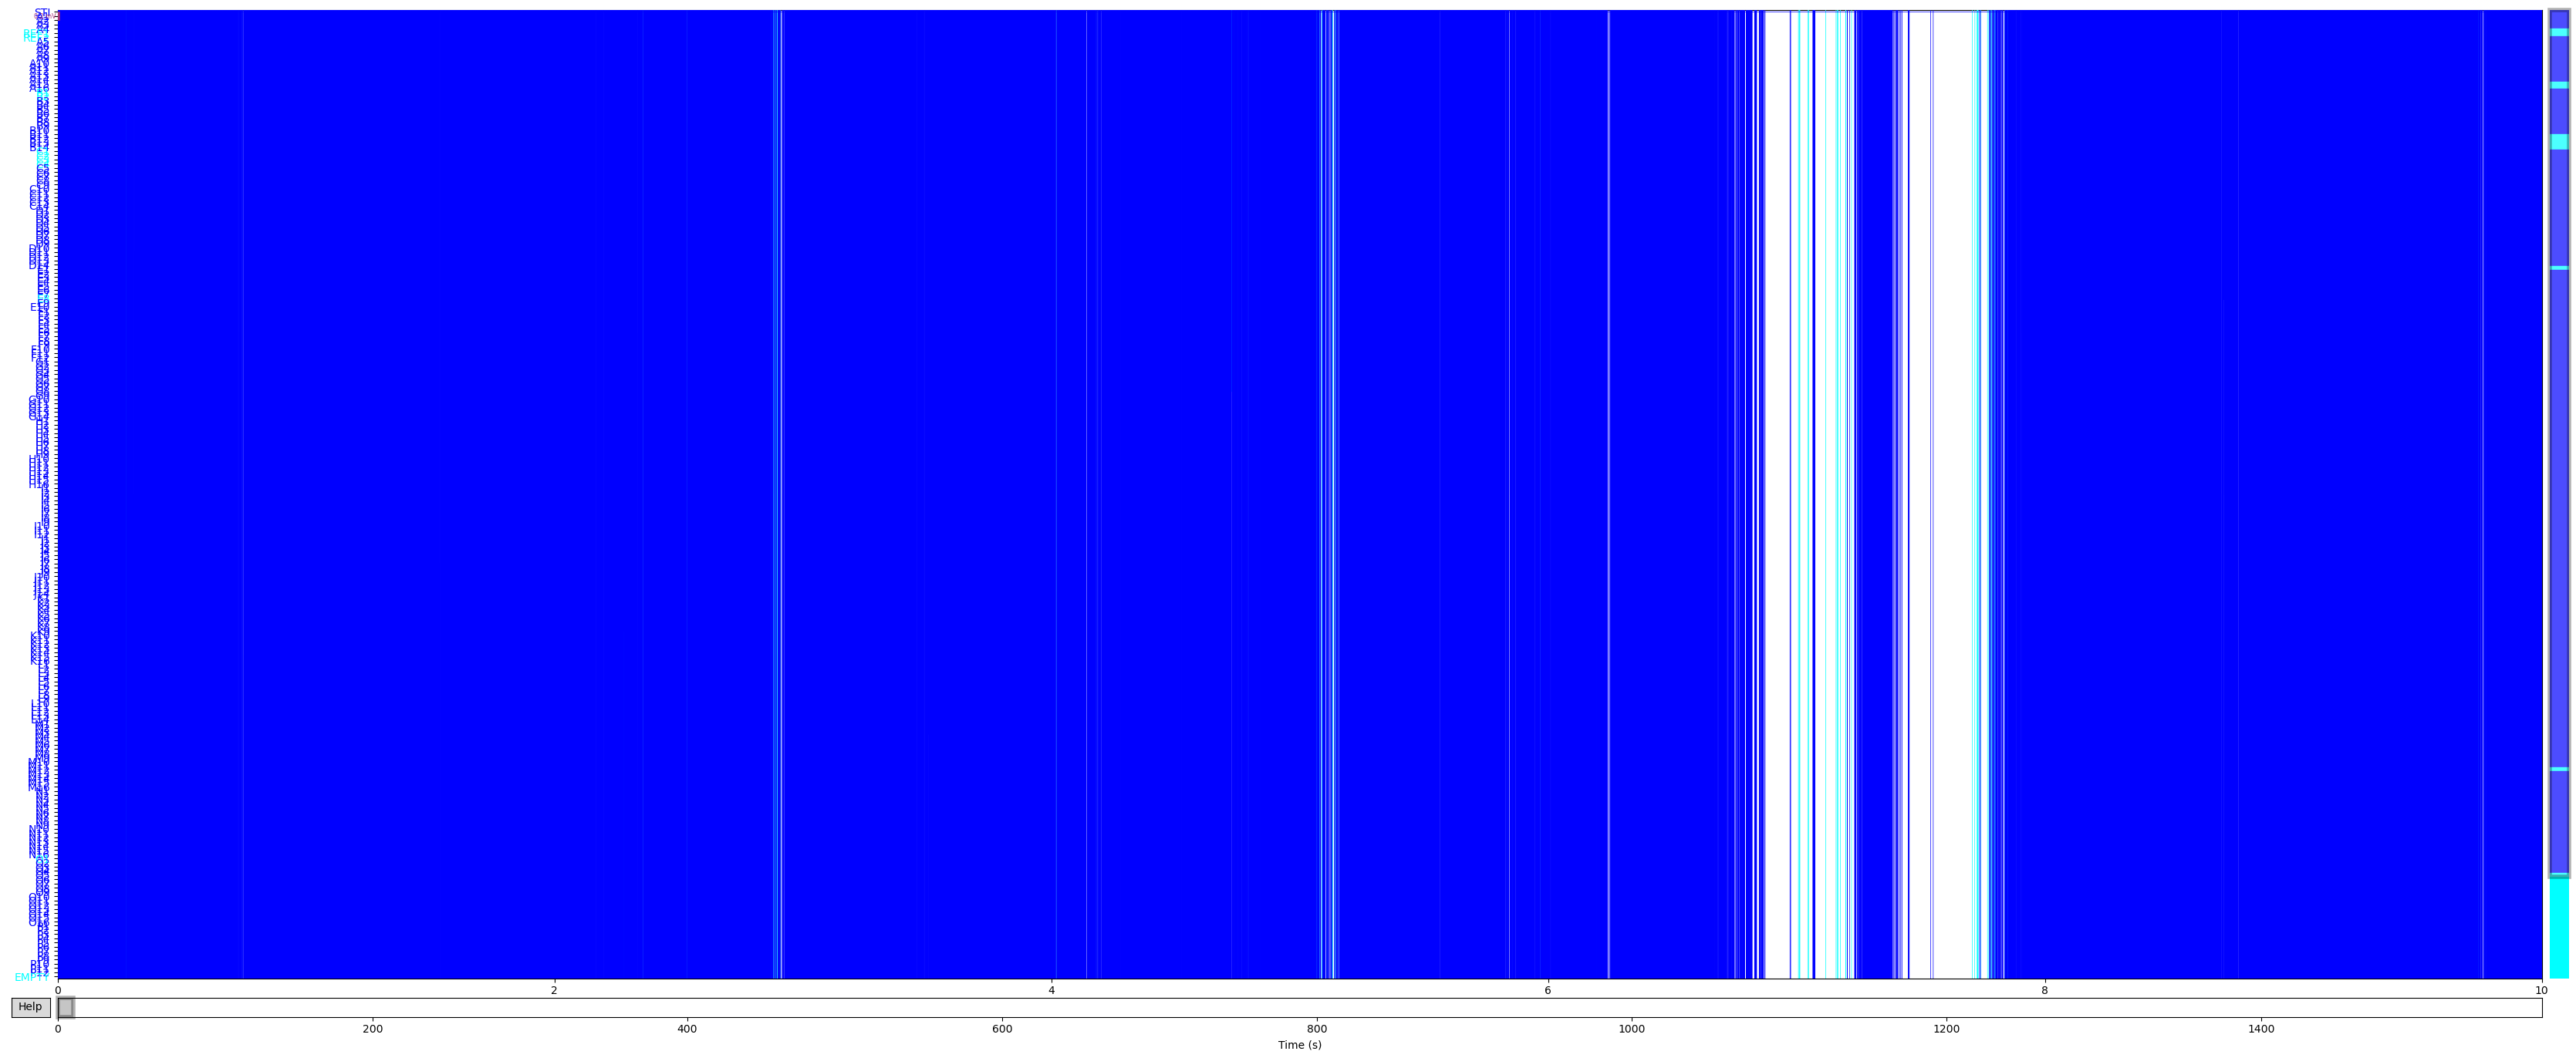

No annotation-label exists! Add one by typing the name and clicking on "Add new label" in the annotation-dialog.
Closing raw-browser...
Channels marked as bad:
['REF1', 'REF2', 'EMPTY', 'EMPTY_230', 'EMPTY_231', 'EKG1', 'EKG2', 'B2', 'B1', 'C1', 'C2', 'C3', 'C4', 'E8', 'O1', 'EMPTY', 'EMPTY_230', 'EMPTY_231', 'fp1', 'f3', 'c3', 'p3', 'o1', 'fp2', 'f4', 'c4', 'p4', 'o2', 'f7', 't7', 'p7', 'f8', 't8', 'p8', 'f9', 'f10', 'fpz', 'fz', 'cz', 'pz', 'oz', 'EKG1', 'EKG2', 'A1', 'H7']


In [12]:
# plot for cleaning #

filtered_notch_data.plot(events=events, color='b', bad_color = 'cyan', n_channels = 230, clipping = None, event_color = 'r')

In [39]:
## From interactive sessions
# interactive_annot = filtered_notch_data.annotations
# for x in range(0, 16):
#     print(interactive_annot[x])
    
    
# filtered_notch_data.annotations[3:16].save('../ieeg/saved_annotations.fif')    

OrderedDict([('onset', 150.02797979687392), ('duration', 0.1893907751345978), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 180.01179324126244), ('duration', 0.10245730458103708), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 250.5178702305566), ('duration', 0.15213357346877387), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 268.2265523281082), ('duration', 0.16765740749622182), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 371.69147208303013), ('duration', 0.19560030874555423), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 628.2482856957466), ('duration', 0.14902880666329565), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 734.2560094643613), ('duration', 0.45640072040635005), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 748.8692390568438), ('duration', 0.2949528465211415), ('description', 'BAD_'), ('orig_time', None)])

/tmp/ipykernel_2785/2527614314.py:5: RuntimeWarning: This filename (../ieeg/saved_annotations.fif) does not conform to MNE naming conventions. All annotations files should end with -annot.fif, -annot.fif.gz, _annot.fif, _annot.fif.gz, .txt or .csv
  filtered_notch_data.annotations[3:16].save('../ieeg/saved_annotations.fif')


Setting 104000 of 2846600 (3.65%) samples to NaN, retaining 2742600 (96.35%) samples.


libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


Effective window size : 1.024 (s)


/tmp/ipykernel_4028/3671565419.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_notch_data.plot_psd()


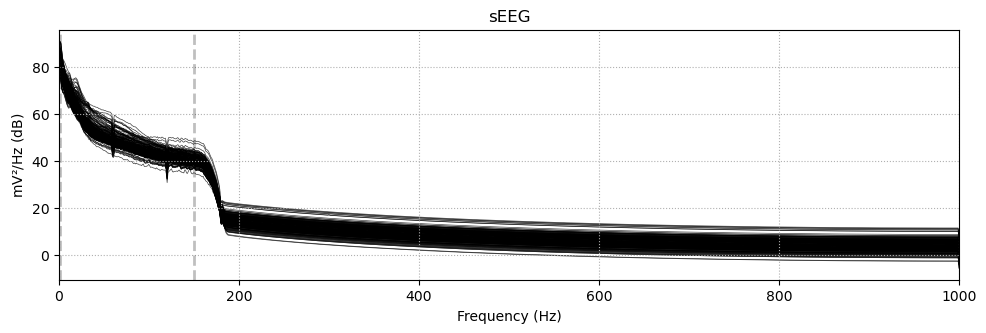

In [13]:
# plot psd of all channels #

filtered_notch_data.plot_psd()

In [ ]:
# plot psd of bad channels #

filtered_notch_data.plot_psd(picks = filtered_notch_data.info['bads'])

## Save Files

In [20]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)


Writing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_clean_ieeg.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_notched_filtered_clean_ieeg.fif
[done]
Writing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_clean_ieeg.fif
Overwriting existing file.
Writing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH021/ieeg/BJH021_raw_clean_ieeg.fif
[done]
